In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!nvidia-smi

Thu Nov 20 10:34:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score

np.random.seed(2562)
PYTHONHASHSEED = 2562
tf.random.set_seed(2562)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
df_train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/train_FD004.txt", sep=" ", header=None)
df_test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/test_FD004.txt", sep=" ", header=None)
df_RUL = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/RUL_FD004.txt", sep=" ", header=None)

train_copy = df_train
test_copy = df_test

# 간단한 전처리
(NaN Columns 제거 및 라벨 설정)

In [5]:
# 데이터 차원 목록
print("\n Train Dimension: ", df_train.shape)
print("\n Test Dimension: ", df_test.shape)
print("\n RUL Dimension: ", df_RUL.shape)


 Train Dimension:  (61249, 28)

 Test Dimension:  (41214, 28)

 RUL Dimension:  (248, 2)


In [6]:
# NaN 데이터 확인
print("\n no missing value Train: \n", df_train.isnull().sum().head(30))
print("\n no missing value Test: \n", df_test.isnull().sum().head(30))
print("\n no missing value Test: \n", df_RUL.isnull().sum().head(30))


 no missing value Train: 
 0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    61249
27    61249
dtype: int64

 no missing value Test: 
 0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    41214
27    41214
dtype: int64

 no missing value Test: 
 0      0
1    248
dtype: int64


In [7]:
# NaN columns 제거
df_train.drop(columns=[26,27], axis=1, inplace=True)
df_test.drop(columns=[26,27], axis=1, inplace=True)
df_RUL.drop(columns=[1], axis=1, inplace=True)

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [8]:
df_train.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25],
      dtype='int64')

In [9]:
# columns 이름 라벨에 맞춰 재설정
columns_train = ['unit_ID','time_in_cycles','setting_1', 'setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

df_train.columns = columns_train
df_test.columns = columns_train

df_train.columns

Index(['unit_ID', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3',
       'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
       'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd',
       'PCNfR_dmd', 'W31', 'W32'],
      dtype='object')

# 데이터 탐색

탐색 코드 시작

/tmp/ipython-input-277380737.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='Spectral') #check castings


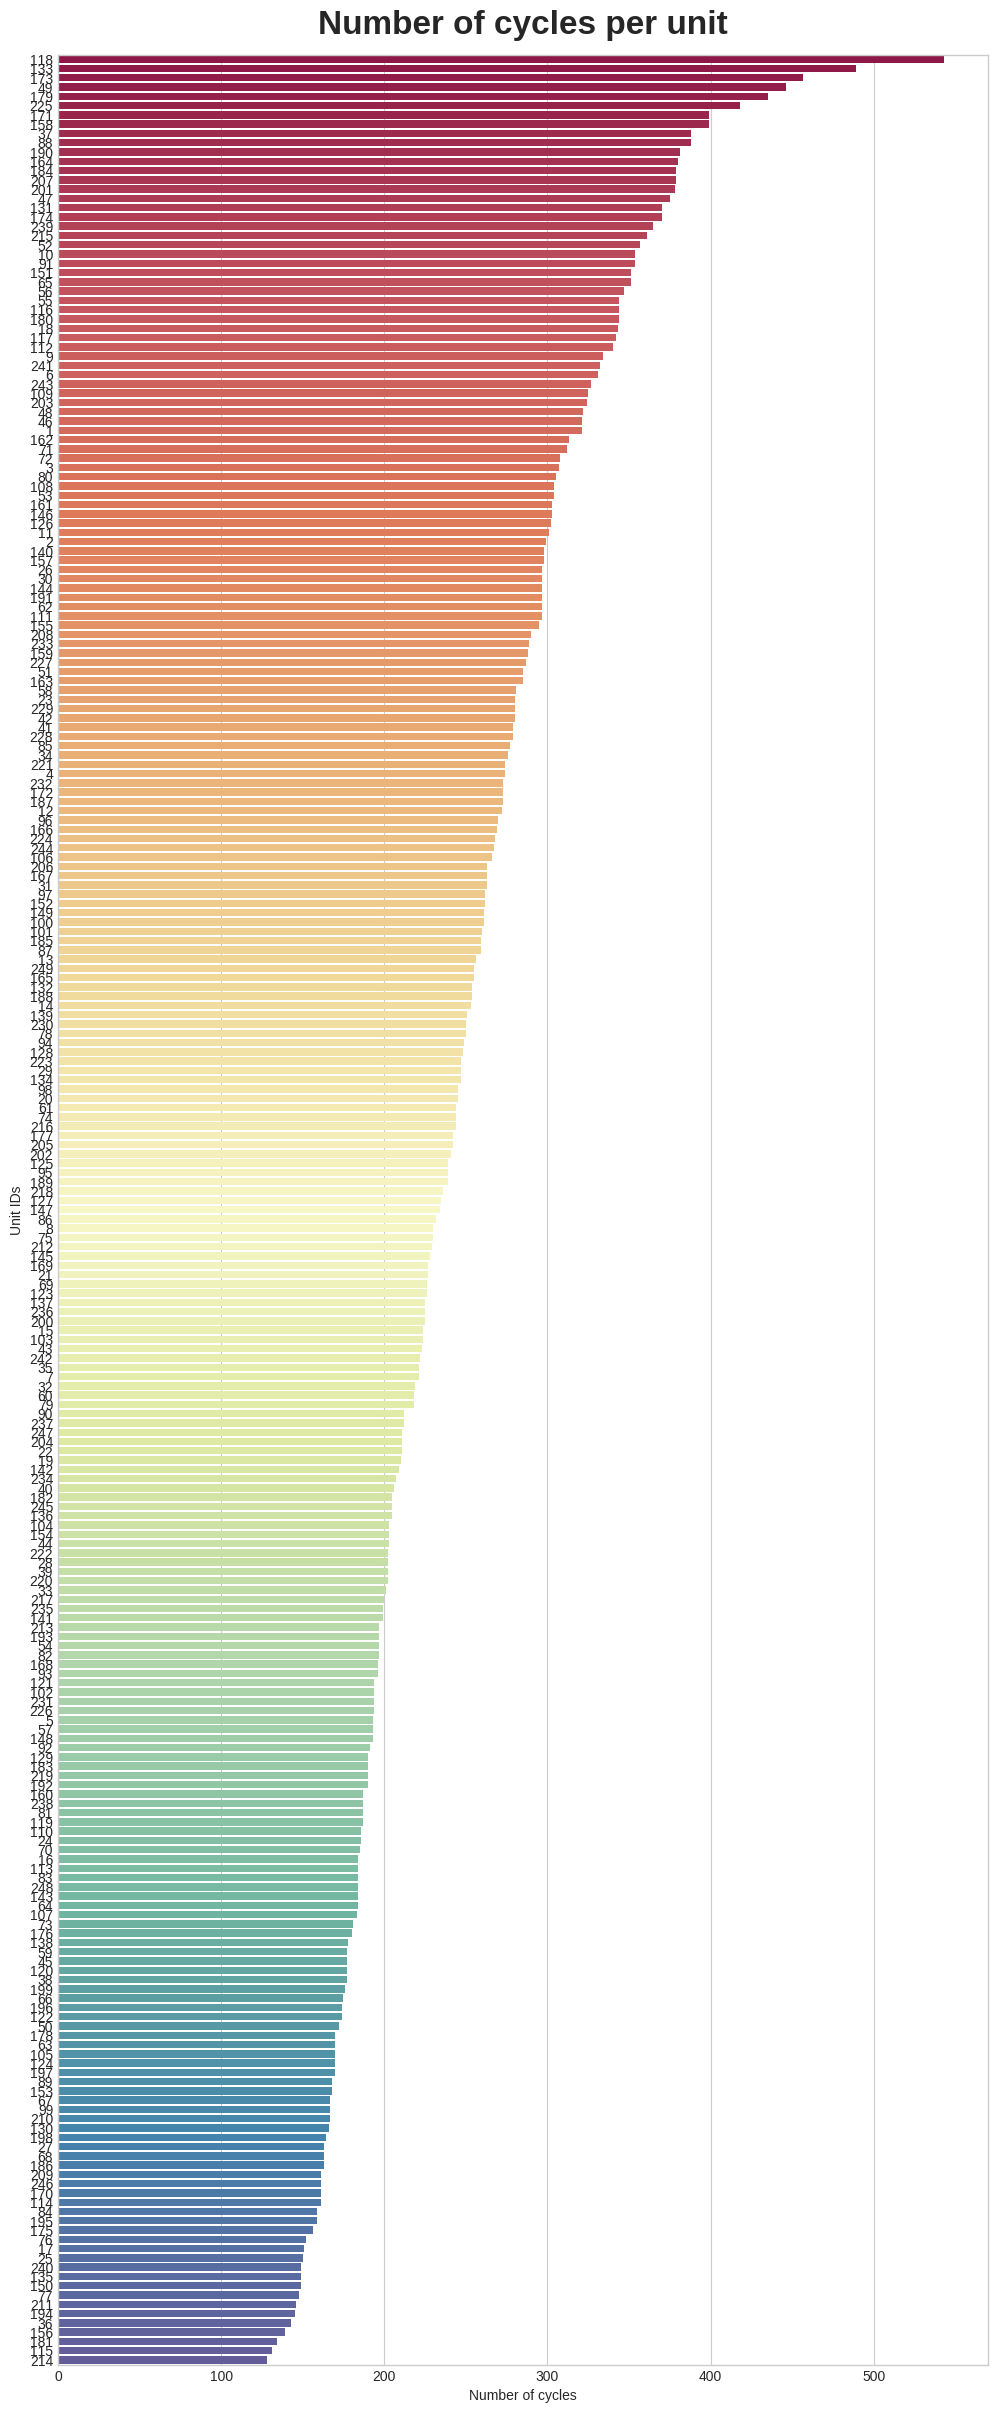

In [10]:
cnt_train = df_train[["unit_ID", "time_in_cycles"]].groupby("unit_ID").max().sort_values(by="time_in_cycles", ascending=False)
cnt_ind = [str(i) for i in cnt_train.index.to_list()]
cnt_val = list(cnt_train.time_in_cycles.values)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(12, 30))
sns.barplot(x=list(cnt_val), y=list(cnt_ind), palette='Spectral') #check castings
plt.xlabel('Number of cycles')
plt.ylabel('Unit IDs')
plt.title('Number of cycles per unit', fontweight='bold', fontsize=24, pad=15)

plt.show()

#센서별 값 검사

/tmp/ipython-input-2310616282.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='husl')
/tmp/ipython-input-2310616282.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


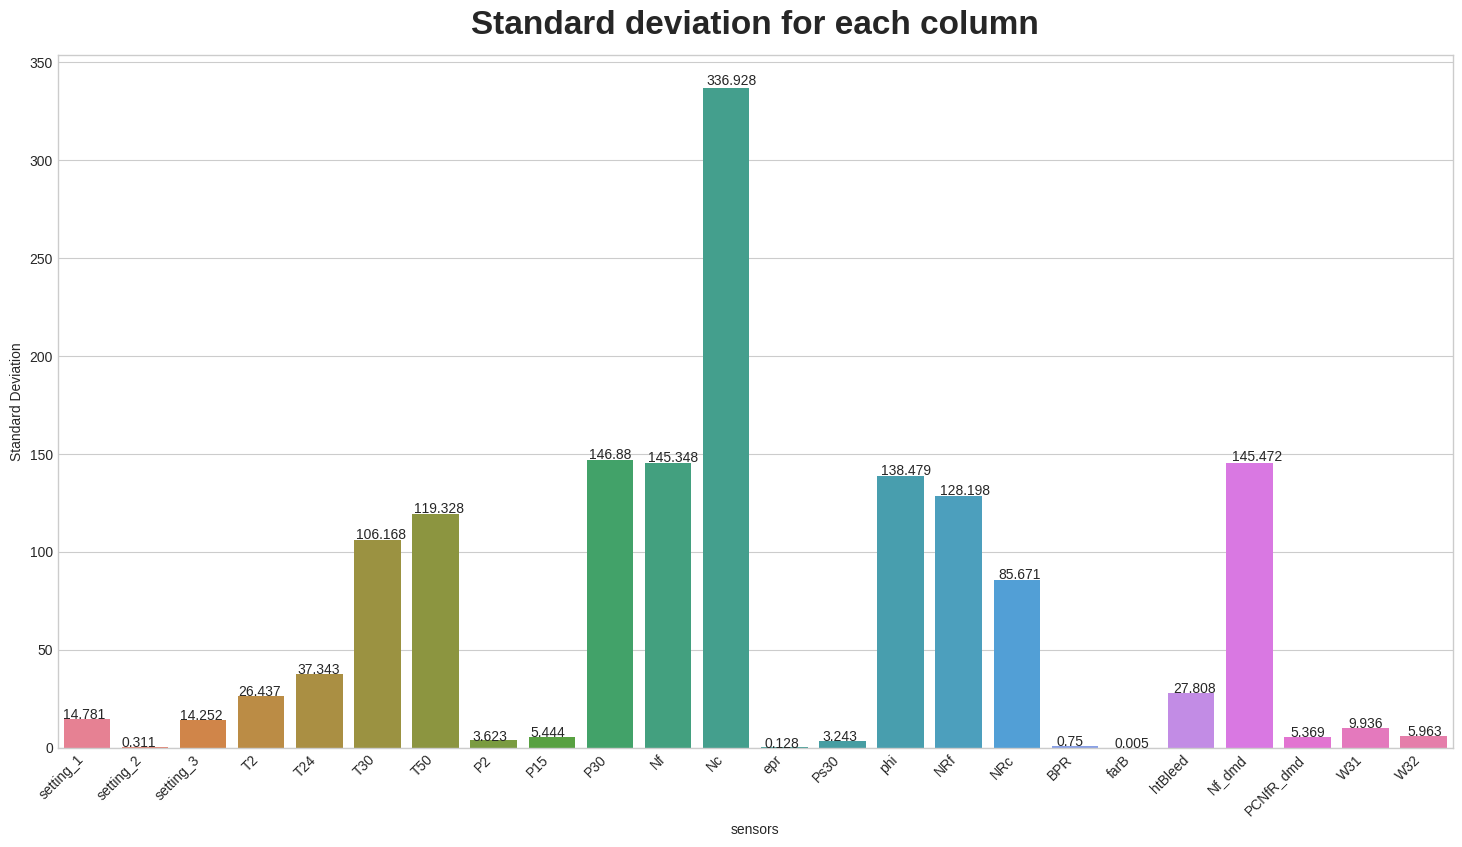

In [11]:
plt.figure(figsize=(18, 9))
subset_stats = df_train.agg(['mean', 'std']).T[2:]
ax = sns.barplot(x=subset_stats.index, y="std", data=subset_stats, palette='husl')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("sensors")
ax.set_ylabel("Standard Deviation")
ax.set_title("Standard deviation for each column", fontweight='bold', fontsize=24, pad=15)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

#Correlation matrix
correlation is a measure that indicates the linear relationship between two random variables. It is always between -1 and 1, where:

-1 means that the two variables have an inverse linear relationship, i.e. as one increases, the other decreases.
1 means that the two variables have a direct linear relationship, i.e. as one increases, the other also increases.
0 means that it is not possible to establish a linear trend between the two variables.

In [12]:
train = df_train.copy()
#train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','setting_3','farB','epr'],inplace=True)

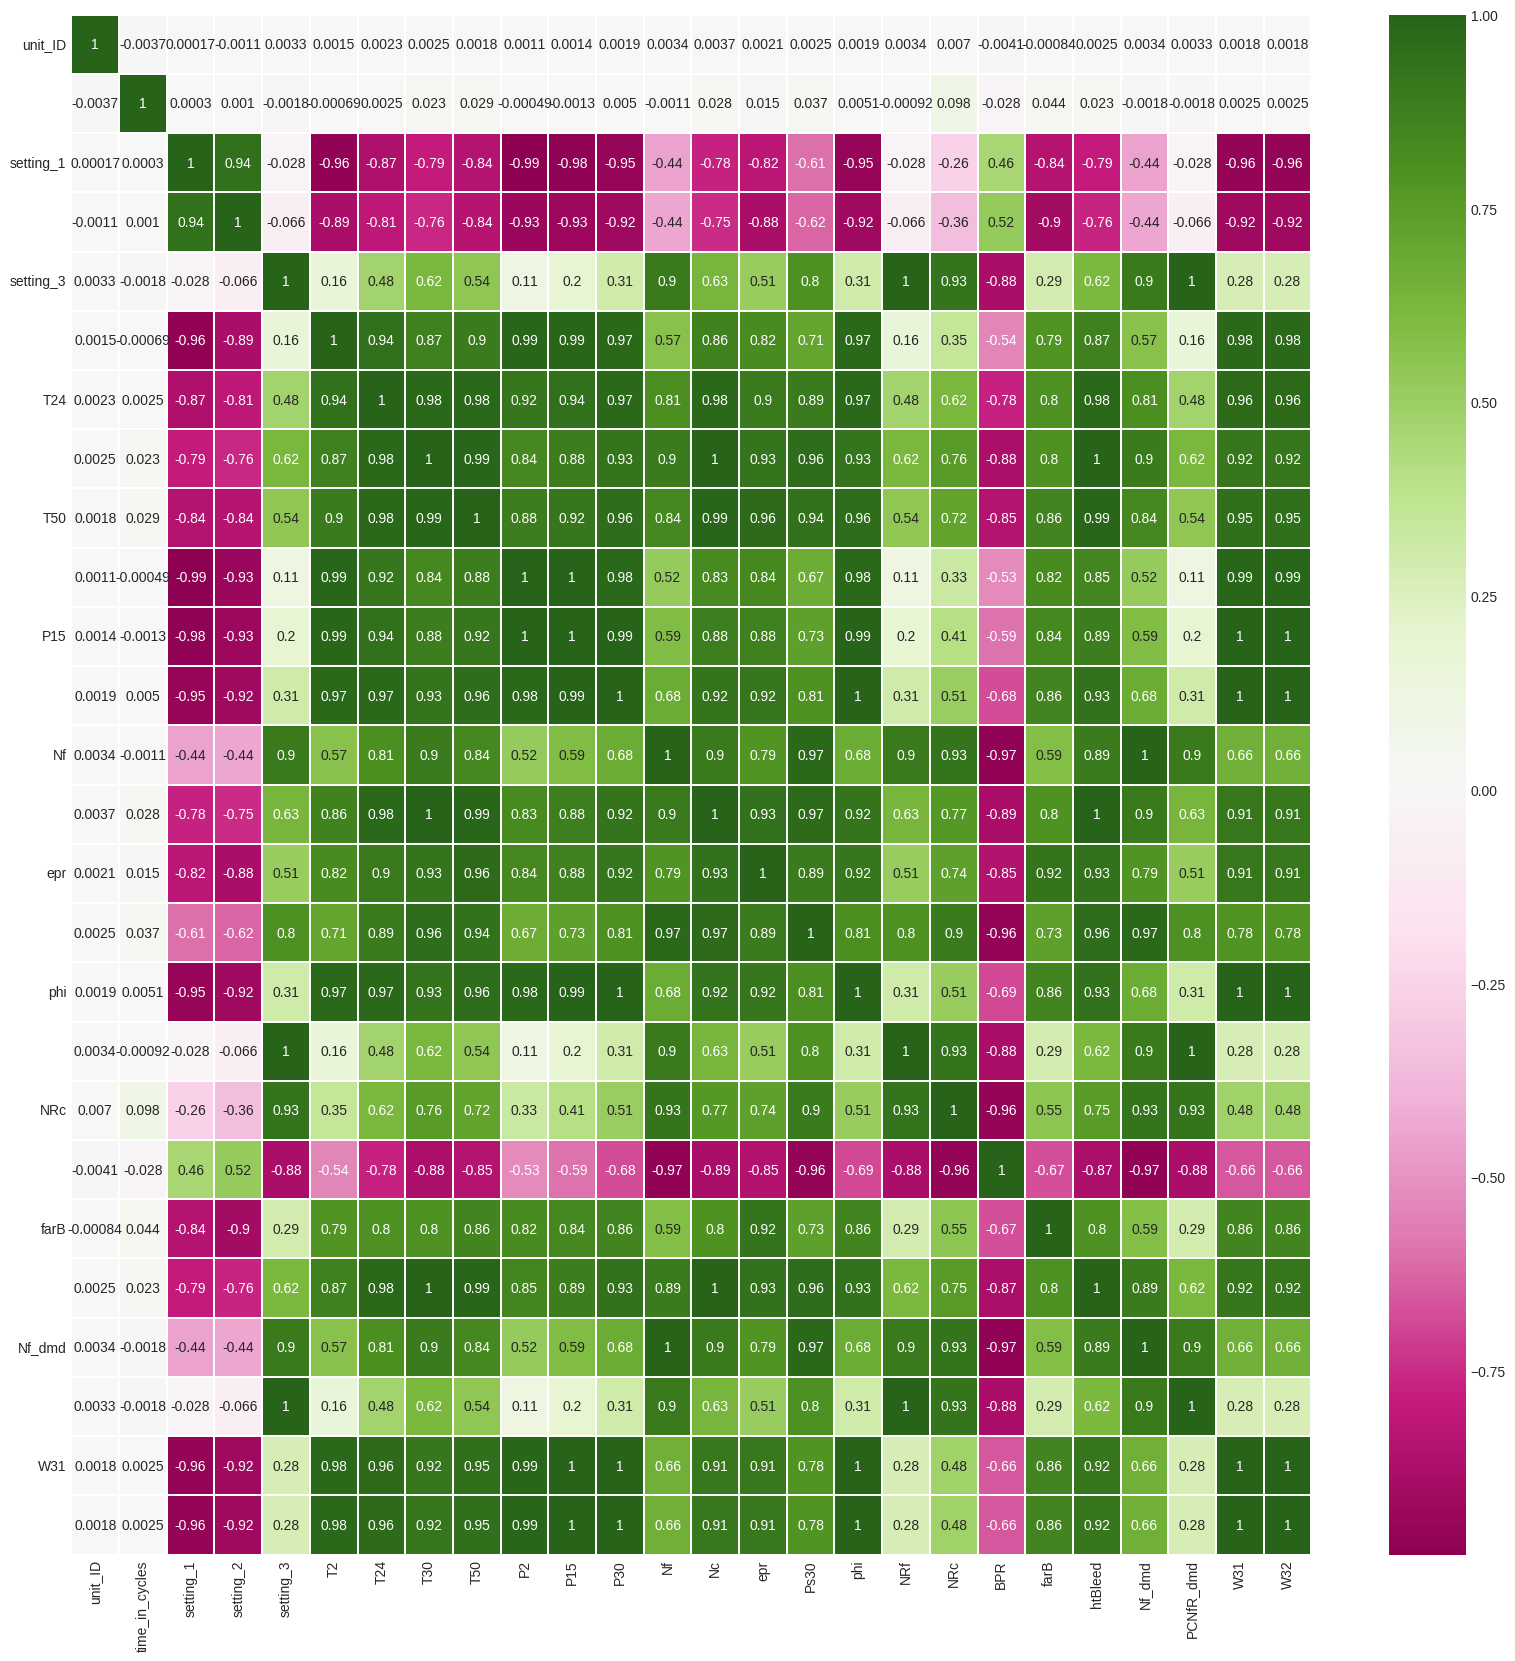

In [13]:
cm = sns.heatmap(train.corr(), annot=True, cmap='PiYG', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

# Model definition
#Data Labeling and Data Normalization
removed the issue of columns w0 and w1, I think he has a differently split dataset...

I also deleted the part where it assigns w0 and w1 to columns it calls 'label'

later I make an attempt to add these empty columns called label to see what happens

In [14]:
#######
# TRAIN
#######
# Data Labeling - column generation RUL(Remaining Usefull Life)
rul = pd.DataFrame(df_train.groupby('unit_ID')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_ID', 'max']
df_train = df_train.merge(rul, on=['unit_ID'], how='left')
df_train['RUL'] = df_train['max'] - df_train['time_in_cycles']
df_train.drop('max', axis=1, inplace=True)


df_train['RUL'] = df_train['RUL'].clip(upper=200)
#  Normalization MinMax (from 0 to 1)
df_train['cycle_norm'] = df_train['time_in_cycles']
cols_normalize = df_train.columns.difference(['unit_ID','time_in_cycles','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]),
                             columns=cols_normalize,
                             index=df_train.index)
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)

sensor_cols = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
               'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd',
               'PCNfR_dmd', 'W31', 'W32']

# join_df 업데이트
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)
df_train = join_df

In [15]:
df_train.columns

Index(['RUL', 'time_in_cycles', 'unit_ID', 'BPR', 'NRc', 'NRf', 'Nc', 'Nf',
       'Nf_dmd', 'P15', 'P2', 'P30', 'PCNfR_dmd', 'Ps30', 'T2', 'T24', 'T30',
       'T50', 'W31', 'W32', 'cycle_norm', 'epr', 'farB', 'htBleed', 'phi',
       'setting_1', 'setting_2', 'setting_3'],
      dtype='object')

In [16]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
df_test['cycle_norm'] = df_test['time_in_cycles']
cols_normalize_2 = df_test.columns.difference(['unit_ID','time_in_cycles','RUL'])
norm_test_df = pd.DataFrame(min_max_scaler.transform(df_test[cols_normalize_2]),
                            columns=cols_normalize_2,
                            index=df_test.index)

# test_join_df 업데이트
test_join_df = df_test[df_test.columns.difference(cols_normalize_2)].join(norm_test_df)
df_test = test_join_df
df_test = df_test.reset_index(drop=True)

In [17]:
df_test.columns

Index(['time_in_cycles', 'unit_ID', 'BPR', 'NRc', 'NRf', 'Nc', 'Nf', 'Nf_dmd',
       'P15', 'P2', 'P30', 'PCNfR_dmd', 'Ps30', 'T2', 'T24', 'T30', 'T50',
       'W31', 'W32', 'cycle_norm', 'epr', 'farB', 'htBleed', 'phi',
       'setting_1', 'setting_2', 'setting_3'],
      dtype='object')

In [18]:
######
# REAL RUL
######
true_rul = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/federated learning/CMAPSSData/RUL_FD004.txt", sep = '\\s+', header = None)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(df_test.groupby('unit_ID')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_ID', 'max']
true_rul.columns = ['more']
true_rul['unit_ID'] = true_rul.index + 1
true_rul['max'] = rul['max'] + true_rul['more']
true_rul.drop('more', axis=1, inplace=True)

# generate RUL for test data
df_test = df_test.merge(true_rul, on=['unit_ID'], how='left')
df_test['RUL'] = df_test['max'] - df_test['time_in_cycles']
df_test.drop('max', axis=1, inplace=True)

# # generate label columns w0 and w1 for test data
# df_test['label1'] = np.where(df_test['RUL'] <= w1, 1, 0 )
# df_test['label2'] = df_test['label1']
# df_test.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [19]:
#I add the columns label 1 and label 2 to the train and test
#I guess because I will put the new values there? who know

n_train = df_train.shape[0]
n_test = df_test.shape[0]
df_train = df_train.assign(label1=[None]*n_train, label2=[None]*n_train)
df_test = df_test.assign(label1=[None]*n_test, label2=[None]*n_test)

In [20]:
true_rul.head(100)

,unit_ID,max
0,1,252
1,2,192
2,3,248
3,4,283
4,5,200
...,...,...
95,96,194
96,97,156
97,98,195
98,99,274


In [21]:
#I add the columns label 1 and label 2 to the train and test
#I guess because I will put the new values there? who know

n_train = df_train.shape[0]
n_test = df_test.shape[0]
df_train = df_train.assign(label1=[None]*n_train, label2=[None]*n_train)
df_test = df_test.assign(label1=[None]*n_test, label2=[None]*n_test)

In [22]:
# pick a large window size of 30 cycles
sequence_length = 30    #윈도우 사이즈 30

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [23]:
# pick the feature columns
sensor_cols = ['T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
#sequence_cols = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm', 'PCA_1', 'PCA_2', 'PCA_3']
# sequence_cols = ['setting_1', 'setting_2', 'setting_3', 'cycle_norm']
# sequence_cols.extend(sensor_cols)

# TODO for debug
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(df_train[df_train['unit_ID']==1], sequence_length, sensor_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(df_train[df_train['unit_ID']==id], sequence_length, sensor_cols))
           for id in df_train['unit_ID'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

291
(53779, 30, 21)


In [24]:
# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(df_train[df_train['unit_ID']==id], sequence_length, ['RUL'])
             for id in df_train['unit_ID'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(53779, 1)

In [25]:
# define path to save model
model_path = 'regression_model.keras'

In [26]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse_keras(y_true, y_pred):
    """Root Mean Square Error (RMSE)"""
    K.square(y_true - y_pred) #: MSE를 계산
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


In [27]:
model = Sequential()
# 첫 번째 LSTM 층 (128 유닛, return_sequences=True)
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=128,
         return_sequences=True))
model.add(Dropout(0.3))
# 두 번째 LSTM 층 (64 유닛, return_sequences=False)
model.add(LSTM(
         units=64,
         return_sequences=False))
model.add(Dropout(0.2))
# 최종 Dense 출력 층 (RUL 예측: nb_out=1)
model.add(Dense(units=nb_out))
model.add(Activation("linear"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
'''
model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=128))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(units=64))
model.add(Activation("relu"))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
'''

'\nmodel = Sequential()\nmodel.add(LSTM(\n         input_shape=(sequence_length, nb_features),\n         units=100,\n         return_sequences=False))\nmodel.add(Dropout(0.3))\nmodel.add(Dense(units=128))\nmodel.add(Activation("relu"))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(units=64))\nmodel.add(Activation("relu"))\nmodel.add(Dense(units=nb_out))\nmodel.add(Activation("linear"))\n'

In [29]:


#optimizer = keras.optimizers.Adam(learning_rate=0.01) # Learning rate 0.01 명시
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae',r2_keras, rmse_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=50, batch_size=32, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )



# list all data in history
print(history.history.keys())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,273 (493.25 KB)

 Trainable params: 126,273 (493.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1597/1597 - 17s - 11ms/step - loss: 8042.3721 - mae: 73.0392 - r2_keras: -1.0103e+00 - rmse_keras: 88.0381 - val_loss: 4430.7007 - val_mae: 56.2213 - val_r2_keras: -3.9594e+11 - val_rmse_keras: 57.7073
Epoch 2/50
1597/1597 - 12s - 8ms/step - loss: 4360.6460 - mae: 57.0060 - r2_keras: -7.8801e-02 - rmse_keras: 65.8109 - val_loss: 4020.9971 - val_mae: 54.9100 - val_r2_keras: -2.5581e+11 - val_rmse_keras: 57.0130
Epoch 3/50
1597/1597 - 20s - 12ms/step - loss: 4229.0620 - mae: 56.5671 - r2_keras: -4.5491e-02 - rmse_keras: 64.8367 - val_loss: 4028.0159 - val_mae: 54.9808 - val_r2_keras: -2.4911e+11 - val_rmse_keras: 57.1178
Epoch 4/50
1597/1597 - 12s - 7ms/step - loss: 4232.9248 - mae: 56.6205 - r2_keras: -4.6499e-02 - rmse_keras: 64.8675 - val_loss: 4027.6433 - val_mae: 54.9773 - val_r2_keras: -2.4940e+11 - val_rmse_keras: 57.1129
Epoch 5/50
1597/1597 - 14s - 9ms/step - loss: 4230.0479 - mae: 56.6050 - r2_keras: -4.5945e-02 - rmse_keras: 64.8459 - val_loss: 4027.8684 - val_

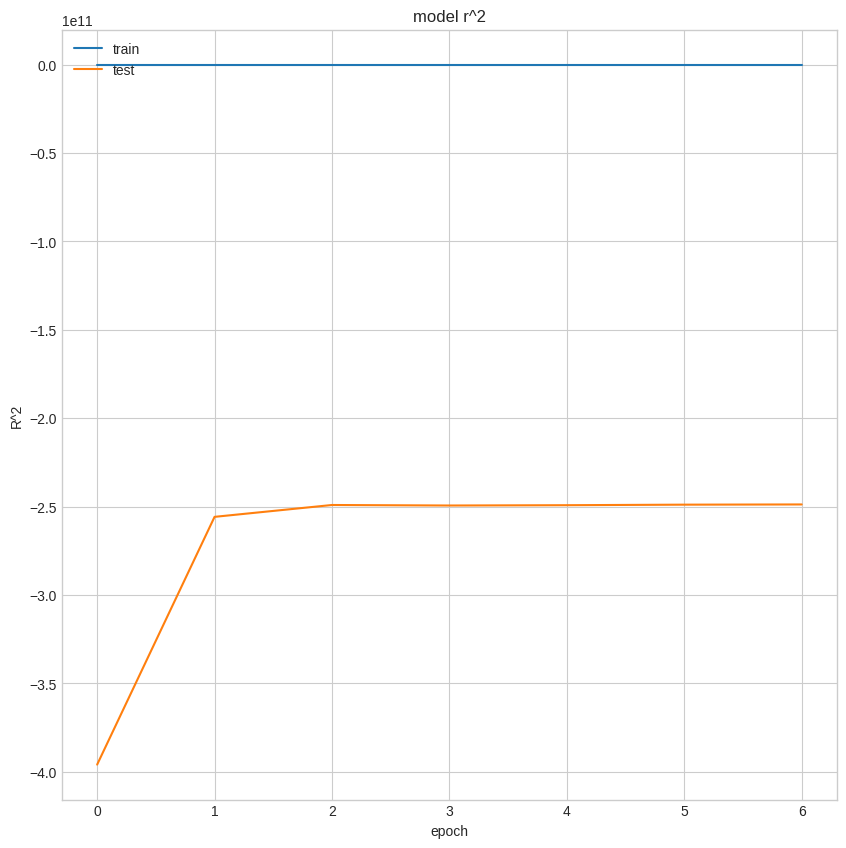

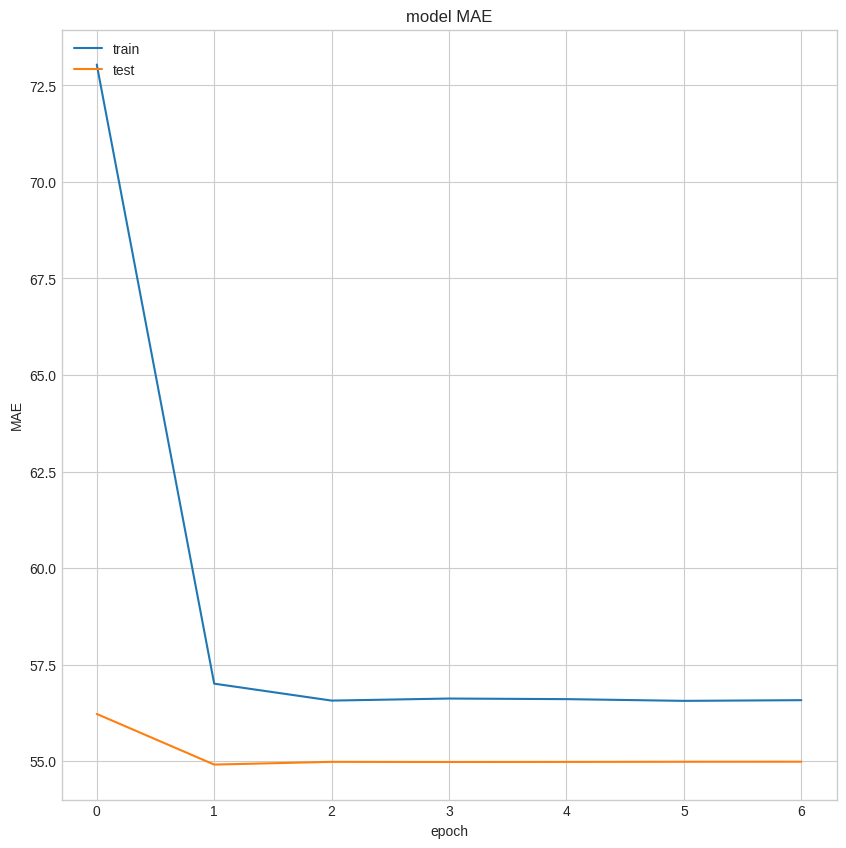

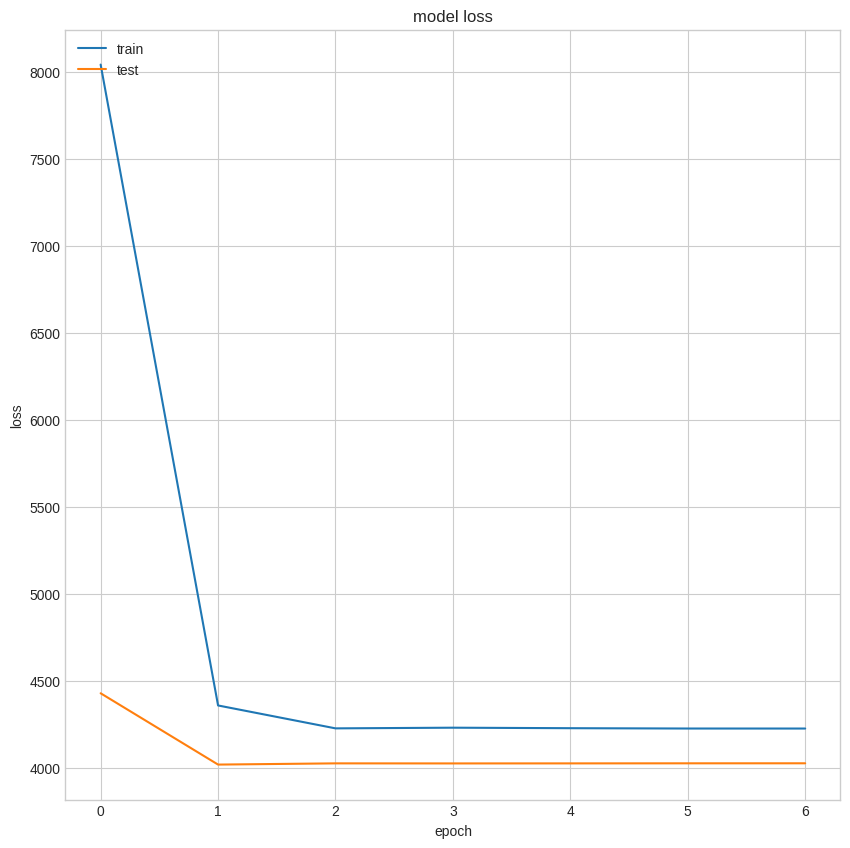

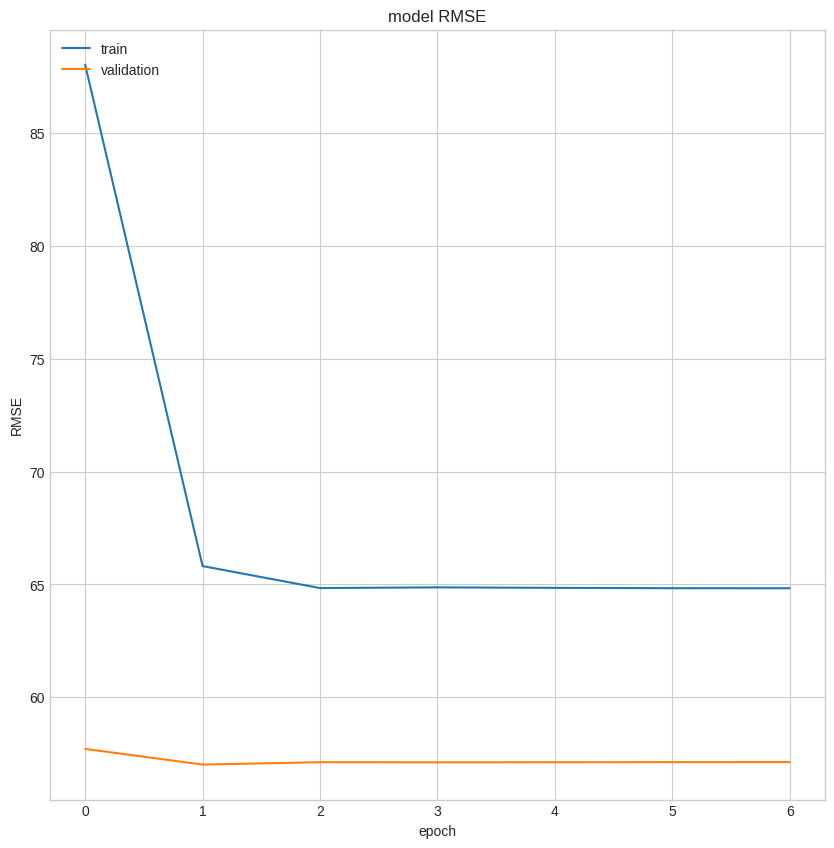

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4204.6396 - mae: 56.6000 - r2_keras: -183847698432.0000 - rmse_keras: 64.0622

MAE: [4175.0546875, 56.29694366455078, -183213588480.0, 63.76068115234375]

R^2: [4175.0546875, 56.29694366455078, -183213588480.0, 63.76068115234375]

RMSE: [4175.0546875, 56.29694366455078, -183213588480.0, 63.76068115234375]
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [30]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['rmse_keras'])
plt.plot(history.history['val_rmse_keras'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') # validation (검증) 데이터셋이므로 'test' 대신 'validation' 사용
plt.show()
fig_acc.savefig("model_rmse.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200) # [3]
print('\nMAE: {}'.format(scores)) # [3]
print('\nR^2: {}'.format(scores)) # [3]
# *** 추가: RMSE 출력 ***
print('\nRMSE: {}'.format(scores))
# ***********************




y_pred = model.predict(seq_array,verbose=1, batch_size=200) # [4]
y_true = label_array # [4]

test_set = pd.DataFrame(y_pred) # [4]
test_set.to_csv('submit_train.csv', index = None) # [4]

8/8 - 2s - 195ms/step - loss: 3450.6282 - mae: 49.5190 - r2_keras: -2.5354e-01 - rmse_keras: 58.5670

Loss: 3450.628173828125

MAE: 49.51900863647461

R^2: -0.25353679060935974

RMSE: 58.56700897216797
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


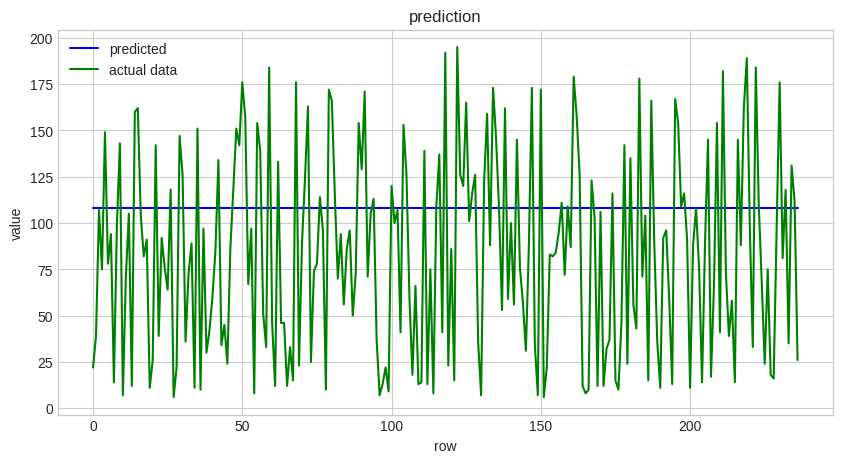

In [32]:
import os
# We pick the last sequence for each id in the test data
seq_array_test_last = [df_test[df_test['unit_ID']==id][sensor_cols].values[-sequence_length:]
                       for id in df_test['unit_ID'].unique() if len(df_test[df_test['unit_ID']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(df_test[df_test['unit_ID']==id]) >= sequence_length for id in df_test['unit_ID'].unique()]
label_array_test_last = df_test.groupby('unit_ID')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'rmse_keras': rmse_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nLoss: {}'.format(scores_test[0]))
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    print('\nRMSE: {}'.format(scores_test[3]))


    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")